# MLBD : Project on the music dataset

The base subject is : Predicting a playlist that satisfies group members (e.g., to decide the music to play in a party). By playlist we mean a set of artists.

Research questions : 
- Can we generate a playlist of artists for multiple users based on what they listened?

## 1. Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.neighbors import NearestNeighbors

import ast
import os

## 2. Load the data

In [2]:
DATA_FOLDER = 'data/'
TOP_FOLDER = DATA_FOLDER + 'lastfm-dataset-360k/'
GROUP_FOLDER = 'data/groups/'
#Using just the artists
top_user = pd.read_csv(TOP_FOLDER + 'usersha1-profile.tsv', sep = '\t', error_bad_lines = False, header = None)
top_data = pd.read_csv(TOP_FOLDER + 'usersha1-artmbid-artname-plays.tsv', sep = '\t', error_bad_lines = False, header = None)

# This file was created using the data expansion done in part 3
spotify_data = pd.read_csv(DATA_FOLDER + 'full_spotify_info.csv', error_bad_lines = False, header = 0)

In [3]:
top_user.head()

,0,1,2,3,4
0,00000c289a1829a808ac09c00daf10bc3c4e223b,f,22.0,Germany,"Feb 1, 2007"
1,00001411dc427966b17297bf4d69e7e193135d89,f,NaN,Canada,"Dec 4, 2007"
2,00004d2ac9316e22dc007ab2243d6fcb239e707d,NaN,NaN,Germany,"Sep 1, 2006"
3,000063d3fe1cf2ba248b9e3c3f0334845a27a6bf,m,19.0,Mexico,"Apr 28, 2008"
4,00007a47085b9aab8af55f52ec8846ac479ac4fe,m,28.0,United States,"Jan 27, 2006"


In [4]:
top_data.head()

,0,1,2,3
0,00000c289a1829a808ac09c00daf10bc3c4e223b,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,f2fb0ff0-5679-42ec-a55c-15109ce6e320,die Ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,b3ae82c2-e60b-4551-a76d-6620f1b456aa,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,3d6bbeb7-f90e-4d10-b440-e153c0d10b53,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,bbd2ffd7-17f4-4506-8572-c1ea58c3f9a8,juliette & the licks,706


As we see, the columns have not proper names, we reformat them in this cell:

In [5]:
#Need to rename the columns
top_user.rename(columns = {0 : 'ID', 1 : 'Gender', 2 : 'Age', 3 : 'Country', 4 : 'Registered'}, inplace = True)
top_data.rename(columns = {0 : 'ID', 1 : 'Artist_ID', 2 : 'Artist', 3 : 'Plays'}, inplace = True)

In [6]:
top_user.shape

(359347, 5)

In [7]:
top_data.shape

(17535655, 4)

We have 359'347 users in the users dataset and 17'535'655 entries of type (user, Artist, Plays)

In [8]:
# we'll check the number of NaNs for each dataset
print(top_user.isna().sum(), '\n')
print(top_data.isna().sum(), '\n')

ID                0
Gender        32775
Age           74900
Country           0
Registered        0
dtype: int64 

ID                0
Artist_ID    226137
Artist          204
Plays             0
dtype: int64 



There is no missing entries for the user dataset, however we miss a lot of artist_ID and some artists name. We therefore remove the 204 artists with no name as there we can't recommand them.

In [9]:
to_drop = top_data[top_data['Artist'].isna()].index
top_data = top_data.drop(to_drop)

Let's see how many artists we have and users that have at least listen to one music:

In [10]:
print(f"The dataset has {len(top_data.groupby('Artist').count())} artists")

The dataset has 292363 artists


In [11]:
nb_users_in_top_data = len(top_data.groupby('ID').count())
print(f"The music dataset has {nb_users_in_top_data} users, meaning that {359347-nb_users_in_top_data} did not listen to anything and have therefore no matching entries")

The music dataset has 358868 users, meaning that 479 did not listen to anything and have therefore no matching entries


## 3. Spotify API Data analysis

We first need to change the Info column from a string to a dictionary

In [12]:
add_data = spotify_data.copy()
add_data['Info'] = add_data['Info'].map(lambda x: x if isinstance(x, str) else "{}").map(lambda x: ast.literal_eval(x))
add_data.head()

,Artist,Info
0,!!!,{'external_urls': {'spotify': 'https://open.sp...
1,!action pact!,{'external_urls': {'spotify': 'https://open.sp...
2,!deladap,{'external_urls': {'spotify': 'https://open.sp...
3,!distain,{'external_urls': {'spotify': 'https://open.sp...
4,!t.o.o.h.!,{'external_urls': {'spotify': 'https://open.sp...


In [13]:
add_data['Genres'] = add_data['Info'].map(lambda x: x['genres'] if len(x) > 0 else [])
add_data.head()

,Artist,Info,Genres
0,!!!,{'external_urls': {'spotify': 'https://open.sp...,"[alternative dance, dance rock, dance-punk, el..."
1,!action pact!,{'external_urls': {'spotify': 'https://open.sp...,"[anarcho-punk, uk82]"
2,!deladap,{'external_urls': {'spotify': 'https://open.sp...,"[balkan brass, electro swing]"
3,!distain,{'external_urls': {'spotify': 'https://open.sp...,"[dark electro, futurepop, neo-synthpop]"
4,!t.o.o.h.!,{'external_urls': {'spotify': 'https://open.sp...,[technical grindcore]


In [14]:
genres = add_data['Genres'].tolist()
all_genres = [item for sublist in genres for item in sublist]
unique_genres = set(all_genres)
len(unique_genres)

4258

In [15]:
from collections import Counter
c = Counter(all_genres)
c.most_common(25)

[('rock', 665),
 ('dance pop', 511),
 ('hip hop', 475),
 ('country rock', 460),
 ('pop rock', 454),
 ('pop', 449),
 ('rap', 415),
 ('mellow gold', 412),
 ('adult standards', 402),
 ('classic rock', 395),
 ('alternative metal', 391),
 ('alternative rock', 387),
 ('soft rock', 387),
 ('folk rock', 381),
 ('pop rap', 366),
 ('indie rock', 362),
 ('album rock', 362),
 ('art rock', 358),
 ('new wave pop', 357),
 ('folk', 356),
 ('urban contemporary', 350),
 ('hard rock', 349),
 ('latin', 346),
 ('funk', 345),
 ('post-teen pop', 334)]

In [16]:
def most_common_genre(l, c) :
    best = ""
    best_num = 0
    for elem in l:
        if(c[elem] > best_num) :
            best = elem
            best_num = c[elem]
    return best

In [17]:
add_data['Most_common_genre'] = add_data['Genres'].map(lambda x: most_common_genre(x, c))
add_data.head()

,Artist,Info,Genres,Most_common_genre
0,!!!,{'external_urls': {'spotify': 'https://open.sp...,"[alternative dance, dance rock, dance-punk, el...",electronica
1,!action pact!,{'external_urls': {'spotify': 'https://open.sp...,"[anarcho-punk, uk82]",uk82
2,!deladap,{'external_urls': {'spotify': 'https://open.sp...,"[balkan brass, electro swing]",balkan brass
3,!distain,{'external_urls': {'spotify': 'https://open.sp...,"[dark electro, futurepop, neo-synthpop]",neo-synthpop
4,!t.o.o.h.!,{'external_urls': {'spotify': 'https://open.sp...,[technical grindcore],technical grindcore


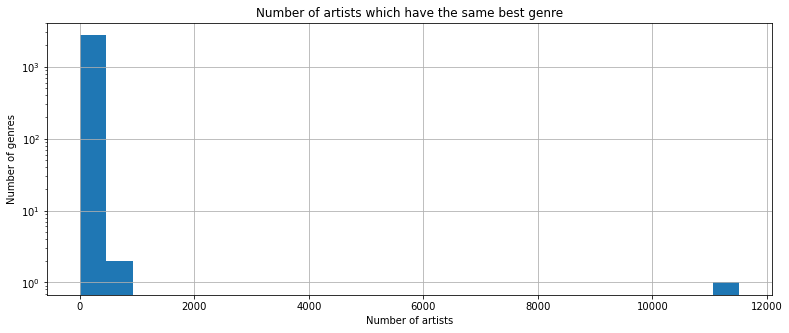

In [18]:

add_data.groupby('Most_common_genre').size().hist(bins = 25, figsize = (13, 5))
plt.yscale('log')
plt.title('Number of artists which have the same best genre')
plt.xlabel('Number of artists')
_ = plt.ylabel('Number of genres')

In [19]:
add_data.groupby('Most_common_genre').size()

Most_common_genre
                    11522
a cappella             20
abstract                4
abstract beats          3
abstract hip hop       42
                    ...  
zim urban groove        1
zither                  1
zolo                   15
zouk                   13
zydeco                  1
Length: 2732, dtype: int64

In this case, we see that there are 11522 artists which do not have any genres attached to them, this probably comes from a lack of information about these artists in general from Spotify.

In [20]:
add_data = add_data[add_data['Genres'].map(len) > 0]

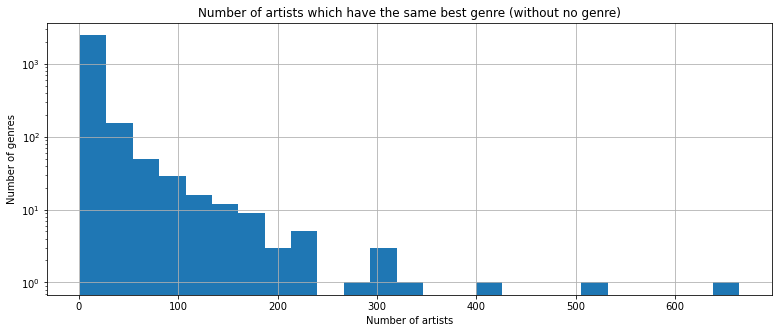

In [21]:
add_data.groupby('Most_common_genre').size().hist(bins = 25, figsize = (13, 5))
plt.yscale('log')
plt.title('Number of artists which have the same best genre (without no genre)')
plt.xlabel('Number of artists')
_ = plt.ylabel('Number of genres')

We can see that there are some issues with the Spotify API part where Artist such as She will be take as Ed Sheeran. This will be fixed by setting a bigger threshold on the number of users which are listening to the same artist.

In [22]:
top_data_percent = top_data.copy()
top_data_percent['Percent'] = top_data['Plays'] / top_data[['ID', 'Plays']].groupby('ID').Plays.transform('sum')
top_data_percent.head()

,ID,Artist_ID,Artist,Plays,Percent
0,00000c289a1829a808ac09c00daf10bc3c4e223b,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,2137,0.127842
1,00000c289a1829a808ac09c00daf10bc3c4e223b,f2fb0ff0-5679-42ec-a55c-15109ce6e320,die Ärzte,1099,0.065745
2,00000c289a1829a808ac09c00daf10bc3c4e223b,b3ae82c2-e60b-4551-a76d-6620f1b456aa,melissa etheridge,897,0.053661
3,00000c289a1829a808ac09c00daf10bc3c4e223b,3d6bbeb7-f90e-4d10-b440-e153c0d10b53,elvenking,717,0.042893
4,00000c289a1829a808ac09c00daf10bc3c4e223b,bbd2ffd7-17f4-4506-8572-c1ea58c3f9a8,juliette & the licks,706,0.042235


In [23]:
all_data = top_data_percent.merge(add_data, on = 'Artist')
all_data.head()

,ID,Artist_ID,Artist,Plays,Percent,Info,Genres,Most_common_genre
0,00000c289a1829a808ac09c00daf10bc3c4e223b,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,2137,0.127842,{'external_urls': {'spotify': 'https://open.sp...,[riot grrrl],riot grrrl
1,0159d9ae1c8d76ab7fe3aa868a38e1da56cc06ab,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,42,0.011105,{'external_urls': {'spotify': 'https://open.sp...,[riot grrrl],riot grrrl
2,0285490bb23814cf0dc18a5668261e243572d4eb,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,41,0.010299,{'external_urls': {'spotify': 'https://open.sp...,[riot grrrl],riot grrrl
3,03d2e7186a6c29f281f6ff8b9bb2f7503822e7de,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,67,0.010819,{'external_urls': {'spotify': 'https://open.sp...,[riot grrrl],riot grrrl
4,04e0999468b2bbd922f0fdd41ffd9a5f26f97609,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,3,0.006122,{'external_urls': {'spotify': 'https://open.sp...,[riot grrrl],riot grrrl


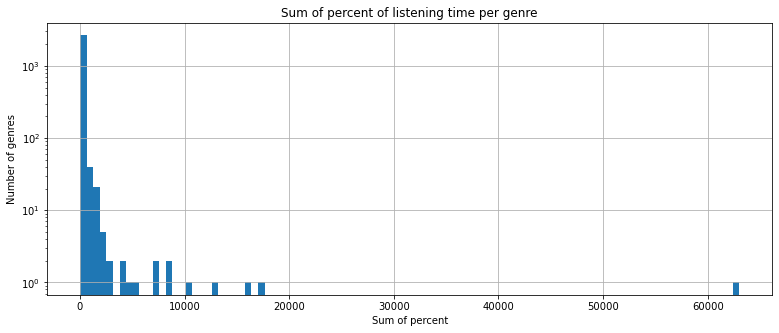

In [24]:
all_data[['Most_common_genre', 'Percent']].groupby('Most_common_genre').sum().hist(bins = 100, figsize = (13, 5))
plt.yscale('log')
plt.title('Sum of percent of listening time per genre')
plt.xlabel('Sum of percent')
_ = plt.ylabel('Number of genres')

In [25]:
all_data[['Most_common_genre', 'Percent']].groupby('Most_common_genre').sum().sort_values(by = 'Percent')

,Percent
Most_common_genre,
kansas city hip hop,0.224099
belarusian pop,0.228380
ukrainian pop,0.242180
death doom,0.248212
backing track,0.254336
...,...
pop rock,10153.227699
electronica,13105.734487
alternative metal,16197.328686


In [26]:
all_data

,ID,Artist_ID,Artist,Plays,Percent,Info,Genres,Most_common_genre
0,00000c289a1829a808ac09c00daf10bc3c4e223b,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,2137,0.127842,{'external_urls': {'spotify': 'https://open.sp...,[riot grrrl],riot grrrl
1,0159d9ae1c8d76ab7fe3aa868a38e1da56cc06ab,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,42,0.011105,{'external_urls': {'spotify': 'https://open.sp...,[riot grrrl],riot grrrl
2,0285490bb23814cf0dc18a5668261e243572d4eb,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,41,0.010299,{'external_urls': {'spotify': 'https://open.sp...,[riot grrrl],riot grrrl
3,03d2e7186a6c29f281f6ff8b9bb2f7503822e7de,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,67,0.010819,{'external_urls': {'spotify': 'https://open.sp...,[riot grrrl],riot grrrl
4,04e0999468b2bbd922f0fdd41ffd9a5f26f97609,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,3,0.006122,{'external_urls': {'spotify': 'https://open.sp...,[riot grrrl],riot grrrl
...,...,...,...,...,...,...,...,...
15553751,d375f346d239a15445b464c7b139b5f11641835b,NaN,as diabatz,149,0.009205,{'external_urls': {'spotify': 'https://open.sp...,"[brazilian rockabilly, psychobilly, rock curit...",psychobilly
15553752,d7a0a0d499c8f9e127d990d5b49225339ad572ba,NaN,as diabatz,120,0.005539,{'external_urls': {'spotify': 'https://open.sp...,"[brazilian rockabilly, psychobilly, rock curit...",psychobilly
15553753,dbdbcec60934d38e130c38cc65b29f56b7c2b8a5,NaN,as diabatz,224,0.025050,{'external_urls': {'spotify': 'https://open.sp...,"[brazilian rockabilly, psychobilly, rock curit...",psychobilly
15553754,ecfedd97388a4a2a3fa2bf7c7e3caa0ab0abf93e,NaN,as diabatz,284,0.011709,{'external_urls': {'spotify': 'https://open.sp...,"[brazilian rockabilly, psychobilly, rock curit...",psychobilly


Instead of the 17'535'655 entries, we now have 15'553'756 that have possess a lot more information

## 4. Exploratory data analysis

Now we look at the number of users that have listened to one artist

In [27]:
artists_nb_users_listen= all_data.groupby(['Artist']).size().sort_values(ascending = True).reset_index(name = 'nb_users')
# we check how many times an artist occurs in dataset
artists_nb_users_listen

,Artist,nb_users
0,da boy tommy,21
1,the bandits,21
2,ameritz,21
3,silber,21
4,maze featuring frankie beverly,21
...,...,...
33096,muse,46954
33097,red hot chili peppers,48924
33098,coldplay,66658
33099,the beatles,76245


In [28]:
artists_nb_users_listen.describe()

,nb_users
count,33101.000000
mean,469.887798
std,1940.298022
min,21.000000
25%,37.000000
50%,80.000000
75%,242.000000
max,77254.000000


As expected, the distribution is exponential. More than 25% of the artists that have a matching entry in the spotify API have been listened only by 37 users, 50% by 80, 75% by 242.


Text(0.5, 0, 'Nb of users')

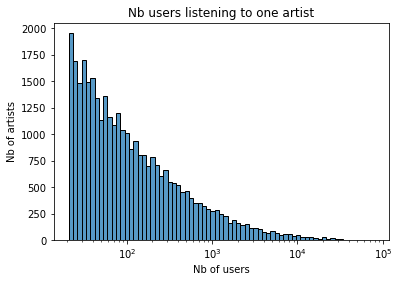

In [29]:
sns.histplot(artists_nb_users_listen['nb_users'], log_scale = True)
plt.title("Nb users listening to one artist")
plt.ylabel("Nb of artists")
plt.xlabel("Nb of users")


#### Now look at the users

In [30]:
users_nb_artists_listen = top_data.groupby('ID').size().sort_values().reset_index(name = 'nb_artists_listen')

In [31]:
users_nb_artists_listen.describe()

,nb_artists_listen
count,358868.000000
mean,48.863234
std,8.524272
min,1.000000
25%,46.000000
50%,49.000000
75%,51.000000
max,166.000000


Interestingly, we see that, although we have a lot of artists, users tend to listen to only a few of them. In average, a users has listened to 49 different artists with the quantiles being near from each other which is good.

Let's now see from where our users come from. It's possible that the origin of the user has an impact on what he listens

In [32]:
nb_users_per_country = top_user.groupby('Country').size().reset_index(name = 'nb_users')

In [33]:
nb_users_per_country = nb_users_per_country.sort_values('nb_users')

<AxesSubplot:xlabel='nb_users', ylabel='Country'>

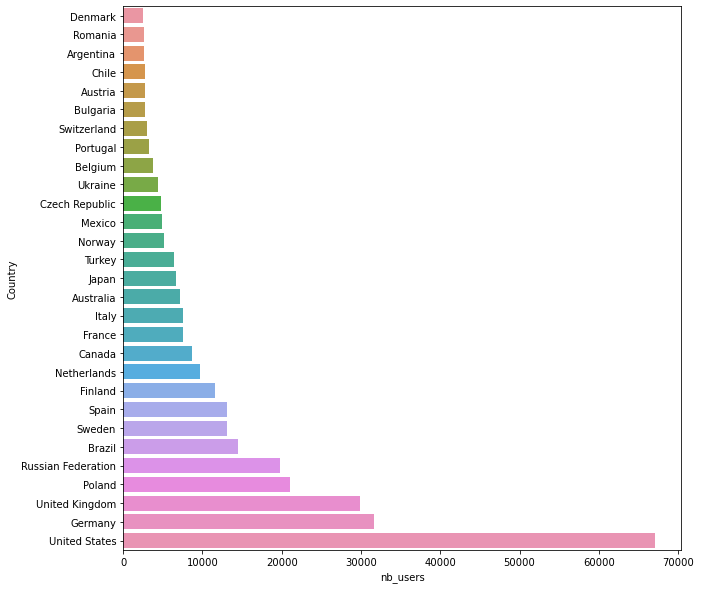

In [34]:
#Only plotting the countries with more than 2000 users in the database
fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(ax= ax, data = nb_users_per_country[nb_users_per_country['nb_users']>2000], x = 'nb_users', y = 'Country', )

We can observe that most of our users come from the United States, Germany and the United Kingdom. More generally, we have a lot of european music culture with the exception of Brazil, Japan, Turkey, Mexico, Chile and Argentinia. We will therefore have that the most listened artists come from this culture. 

Let's now try to merge the two dataset together to continue the exploration

In [35]:
top_merged = all_data.merge(top_user, left_on='ID', right_on='ID')
top_merged = top_merged.drop(columns=['Artist_ID']) ##Drop when the users was registered and the artist_ID

In [36]:
# !!! it seems that we lose approximetely 100k users by merging two datasets above. 
# But I guess we can't do anything with that, but probably it's good to mention it in eda ~rap

# We decide to eliminate users, which have listened to less than 10 favourite artists (We'll use trivial recommendation for them)
top_merged_IDs = top_merged.groupby(['ID']).size().reset_index()
users_id = top_merged_IDs[top_merged_IDs[0] > 10]['ID']
top_merged = top_merged[top_merged['ID'].isin(users_id)]

Let's see if artists are more listened to one country or another

In [37]:
artists_per_country = top_merged[['Artist', 'Country', 'ID', 'Plays']].groupby(['Artist','Country']).agg({'ID': len,
                             'Plays': 'sum'}).rename(columns = {'ID':'nb_users'})

In [38]:
artists_per_country

nb_users  Plays
Artist Country                             
!!!    American Samoa              1   1004
       Andorra                     1     22
       Antarctica                  2    309
       Antigua and Barbuda         1     29
       Argentina                  14   1788
...                              ...    ...
ＬｕＬｕ   Poland                      2    818
       Russian Federation          1     30
       Spain                       1     21
       Sweden                      2    317
       United Kingdom              3    114

[963313 rows x 2 columns]

With this, we can also look at the most listened artist in one country:

In [39]:
top1_artist_per_country = artists_per_country.unstack(1, fill_value = 0)

In [40]:
top1_artist_per_country = top1_artist_per_country.reset_index()
top1_artist_per_country

Artist    nb_users                                         \
Country                Afghanistan Albania Algeria American Samoa Andorra   
0                  !!!           0       0       0              1       1   
1        !action pact!           0       0       0              0       0   
2             !deladap           0       0       0              0       0   
3             !distain           0       0       0              0       0   
4           !t.o.o.h.!           0       0       0              0       0   
...                ...         ...     ...     ...            ...     ...   
33096                비           0       0       0              0       0   
33097               태양           0       0       0              0       0   
33098             푸른새벽           0       0       0              0       0   
33099               １０           0       0       0              0       0   
33100             ＬｕＬｕ           0       0       0              0       0   

                                                        ...   Plays            \
Country Angola Anguilla Antarctica Antigua and Barbuda  ... Vanuatu Venezuela   
0            0        0          2                   1  ...       0      1744   
1            0        0          0                   0  ...       0         0   
2            0        0          0                   0  ...       0         0   
3            0        0          0                   0  ...       0         0   
4            0        0          1                   0  ...       0       389   
...        ...      ...        ...                 ...  ...     ...       ...   
33096        0        0          0                   0  ...       0       893   
33097        0        0          0                   0  ...       0         0   
33098        0        0          0                   0  ...       0         0   
33099        0        0          0                   0  ...       0         0   
33100        0        0          0                   0  ...       0         0   

                                                               \
Country Viet Nam Virgin Islands, British Virgin Islands, U.s.   
0              0                       0                    0   
1              0                       0                    0   
2              0                       0                    0   
3              0                       0                    0   
4              0                       0                    0   
...          ...                     ...                  ...   
33096       1685                       0                    0   
33097          0                       0                    0   
33098          0                       0                    0   
33099          0                       0                    0   
33100          0                       0                    0   

                                                                
Country Wallis and Futuna Western Sahara Yemen Zambia Zimbabwe  
0                     283              0     0      0        0  
1                       0              0     0      0        0  
2                       0              0     0      0        0  
3                       0              0     0      0        0  
4                       0              0     0      0        0  
...                   ...            ...   ...    ...      ...  
33096                   0              0     0      0     1353  
33097                   0              0     0      0        0  
33098                   0              0     0      0        0  
33099                   0              0     0      0        0  
33100                   0              0     0      0        0  

[33101 rows x 479 columns]

In [41]:
top1_artist_per_country = top1_artist_per_country.set_index(top1_artist_per_country['Artist']).drop(columns = 'Artist')

D:\Anaconda\envs\ada\lib\site-packages\pandas\core\generic.py:3887: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [42]:
for country in top1_artist_per_country['nb_users']:
    print(f"Most listened artist in {country}: {top1_artist_per_country['nb_users'][country].idxmax()}, with {top1_artist_per_country['nb_users'][country].max()} users")

Most listened artist in Afghanistan: radiohead, with 12 users
Most listened artist in Albania: metallica, with 14 users
Most listened artist in Algeria: [unknown], with 7 users
Most listened artist in American Samoa: radiohead, with 9 users
Most listened artist in Andorra: obrint pas, with 39 users
Most listened artist in Angola: beyoncé, with 8 users
Most listened artist in Anguilla: muse, with 5 users
Most listened artist in Antarctica: radiohead, with 76 users
Most listened artist in Antigua and Barbuda: radiohead, with 9 users
Most listened artist in Argentina: the beatles, with 812 users
Most listened artist in Armenia: the beatles, with 13 users
Most listened artist in Aruba: the beatles, with 11 users
Most listened artist in Australia: radiohead, with 1983 users
Most listened artist in Austria: die Ärzte, with 572 users
Most listened artist in Azerbaijan: the beatles, with 16 users
Most listened artist in Bahamas: radiohead, with 10 users
Most listened artist in Bahrain: radiohe

Look at it in terms of plays:

In [43]:
for country in top1_artist_per_country['Plays']:
    print(f"Most listened artist in {country}: {top1_artist_per_country['Plays'][country].idxmax()}, with {top1_artist_per_country['Plays'][country].max()} plays")

Most listened artist in Afghanistan: anti-flag, with 4292 plays
Most listened artist in Albania: metallica, with 26215 plays
Most listened artist in Algeria: the devil wears prada, with 5274 plays
Most listened artist in American Samoa: radiohead, with 5038 plays
Most listened artist in Andorra: antònia font, with 14014 plays
Most listened artist in Angola: atmosphere, with 16932 plays
Most listened artist in Anguilla: boards of canada, with 1294 plays
Most listened artist in Antarctica: ildjarn, with 39747 plays
Most listened artist in Antigua and Barbuda: the killers, with 4180 plays
Most listened artist in Argentina: the beatles, with 314047 plays
Most listened artist in Armenia: the beatles, with 11391 plays
Most listened artist in Aruba: the beatles, with 25775 plays
Most listened artist in Australia: radiohead, with 832008 plays
Most listened artist in Austria: nofx, with 477505 plays
Most listened artist in Azerbaijan: massive attack, with 4054 plays
Most listened artist in Baha

We observe that the number of plays and users that listen to an artist doesn't always lead to the same top result. However we can argue that there seem to be cultural differences between the countries leading to different top groups/genres. For example, most nordic countries, have a rock/metal group as top position, while more West-European tend to listen to pop.


We therefore decide to inspect for each users, the max number of plays they have. 

In [44]:
max_top = top_data.groupby(['ID'])['Plays'].max()

Text(0, 0.5, 'Number of users')

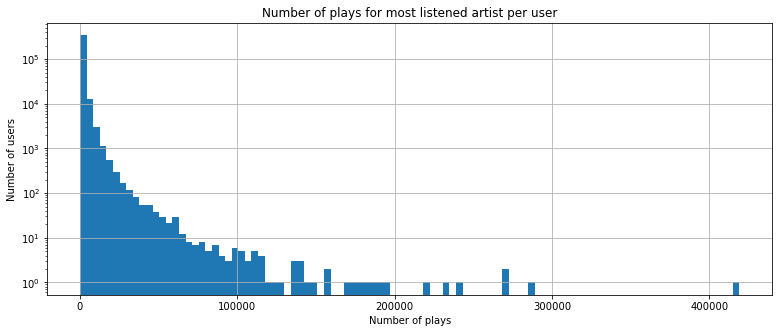

In [45]:
max_top.reset_index().hist(bins = 100, figsize = (13, 5))
plt.yscale('log')
plt.title('Number of plays for most listened artist per user')
plt.xlabel('Number of plays')
plt.ylabel('Number of users')

In [46]:
top_data[top_data['Plays'] == top_data['Plays'].max()]

,ID,Artist_ID,Artist,Plays
9654928,8d0384537845e7f2b1b8b3e8a9f67eb8d9439794,dcaa4f81-bfb7-44eb-8594-4e74f004b6e4,nofx,419157


Most user can be found at the start of scale (notice the logY scale), but some users are truly amazing, with the max plays sitting at 419157. After some research, nofx, the artist this user has been listening to, mainly makes music of about 2 minutes, still this user has more or less listened to 1.6 years of nofx in about 4 years. We really suspect that this is due to a bot. To not have this kind of biases, we argue that taking the number of users listening to an artist is more representative of its fame in the corresponding country

In [47]:
top_user[top_user['ID'] == '8d0384537845e7f2b1b8b3e8a9f67eb8d9439794']

,ID,Gender,Age,Country,Registered
197654,8d0384537845e7f2b1b8b3e8a9f67eb8d9439794,m,31.0,Austria,"Nov 11, 2005"


## 5. Measurement of the quality of the individual recommendation

In [48]:
#Splits the dataframe into a train and a test set randomly
def split_train_test(df, train_size = 0.9 ,seed = 42, apply_seed = False):
    uniques_ids = df.ID.unique()
    if apply_seed:
        np.random.seed(seed)
    train = pd.DataFrame()
    test = pd.DataFrame()
    
    for user_id in uniques_ids:
        user_sub = df[df['ID'] == user_id]
        randomization = np.random.permutation(user_sub.index)
        user_sub_train = user_sub.loc[randomization[0:int(len(randomization)*train_size)]]
        user_sub_test = user_sub.loc[randomization[int(len(user_sub)*train_size):len(user_sub)]]
        
        train = train.append(user_sub_train)
        test = test.append(user_sub_test)
    
    return train, test


Computes just mean absolute error

In [49]:
def compute_mae(pred_method, helper_df):
    mae = 0
    for i, row in test.iterrows():
        user = row.ID
        artist = row.Artist
        prediction = pred_method(user, artist, helper_df)
        mae += abs(row.Plays - prediction)
    return mae/len(test)

Computes accuracy, precision and recall

In [50]:
def compute_appreciation(test_df, pred_method, helper_df, threshold = 250):
    predictions = np.zeros(len(test_df))
    reals = np.zeros(len(test_df))
    indice = 0
    for i, row in test_df.iterrows():
        user = row.ID
        artist = row.Artist
        prediction = pred_method(user, artist, helper_df)
        predictions[indice] = prediction > threshold
        reals[indice] = row.Plays > threshold
        indice += 1
    
    tp = np.sum(np.bitwise_and(predictions==1, reals == 1))
    fp = np.sum(np.bitwise_and(predictions==1, reals == 0))
    
    fn = np.sum(np.bitwise_and(predictions== 0, reals == 1))
    
    acc = np.sum(predictions == reals)
    
    return acc/len(test_df), tp/(tp+fp), tp/(tp + fn)

Computes mae, accuracy, precision and recall in one go

In [51]:
def compute_mae_and_app(test_df, pred_method, helper_df, knn_df = None, knn = None, using_knn = False, threshold = 250):
    predictions = np.zeros(len(test_df))
    reals = np.zeros(len(test_df))
    indice = 0
    mae = 0
    for i, row in test_df.iterrows():
        user = row.ID
        artist = row.Artist
        if using_knn:
            prediction = pred_method(user, artist, helper_df, knn_df, knn)
        else:    
            prediction = pred_method(user, artist, helper_df)
        mae += abs(row.Plays - prediction)
        predictions[indice] = prediction > threshold
        reals[indice] = row.Plays > threshold
        indice += 1
    
    tp = np.sum(np.bitwise_and(predictions==1, reals == 1))
    fp = np.sum(np.bitwise_and(predictions==1, reals == 0))
    
    fn = np.sum(np.bitwise_and(predictions== 0, reals == 1))
    
    acc = np.sum(predictions == reals)
    
    return mae/len(test_df), acc/len(test_df), tp/(tp+fp), tp/(tp + fn)

In [52]:
def compute_n_rounds(pred_method, nb_users_selected = 500, n = 10, n_neighbors = 6,seed = 42):
    """
    Computes the mae, accuracy, precision and recall on n round of the pred_method
    
    pred_method = method that allows to compute the prediction
    nb_users_selected = number of users in the sub-sample
    n = number of rounds
    seed = seed for random generation of sub-samples
    """
    np.random.seed(seed)
    maes, accs, precs, recs = [],[],[],[]
    nb_users = len(top_merged[['ID']].groupby('ID'))
    df = top_merged.groupby('ID').size()
    rng = np.random.default_rng(seed = seed)
    
    for i in range(n):
        print(f"===== Epoch {i} =====")
        selected_users = rng.choice(nb_users, nb_users_selected, replace = False) #Generate a random list of nb_users_select users
        subset_500_users = df[selected_users]
        subset = top_merged[top_merged.ID.isin(subset_500_users.index)]
        train, test = split_train_test(subset, train_size=0.95)
        
        if pred_method == trivial:
            mae = 0 # Makes no sense to compute MAE
            acc, prec, rec = compute_appreciation(test, pred_method, None)
            
        elif pred_method == compute_pred_avg_user:
            avg_user_listens = train[['ID', 'Plays']].groupby("ID").mean('Plays').reset_index()
            mae, acc, prec, rec = compute_mae_and_app(test, pred_method, avg_user_listens)

        elif pred_method == compute_pred_avg_artist:
            avg_artist_listens = train[['Artist', 'Plays']].groupby("Artist").mean('Plays').reset_index()
            mae, acc, prec, rec = compute_mae_and_app(test, pred_method, avg_artist_listens)
            
        elif pred_method == compute_pred_user_item:
            mae, acc, prec, rec = compute_mae_and_app(test, pred_method, train) #sim measures doesn't need a helper set
            
        elif pred_method == compute_pred_knn:
            knn_pivot = subset.pivot_table(index = 'ID', columns = 'Artist', values = 'Plays').fillna(0).astype(bool)
            model_knn = NearestNeighbors(metric='jaccard', n_neighbors=n_neighbors, n_jobs=-1)
            model_knn.fit(knn_pivot)
            mae, acc, prec, rec = compute_mae_and_app(test, pred_method, train, knn_pivot, model_knn, using_knn = True)
        
        
        
        maes.append(mae)
        accs.append(acc)
        precs.append(prec)
        recs.append(rec)
        
    return maes, accs, precs, recs


## 6. Measurment of the quality of the group recommender systems:

For the group recommendation system. We use a least measury principle, meaning we want to satisfy the most users. So for each user we need to get the number of plays, if it is over a certain threshold, we consider he likes it, otherwise not. We then aggregate all the individual predictions and try to select the artist with the most likes.

To measure the performance of this we use the Discounted Cumulative Gain (DCG).

In [53]:
def get_group_recommendation_according_to_our_algorithm(users, same_artists, df, threshold = 250):
    recommendations = pd.DataFrame(columns = ["Artist", "nb_likes"])
    for artist in same_artists:
        nb_likes = 0
        for user in users:
            if df[(df['ID'] == user) & (df['Artist'] == artist)].iloc[0]['Plays'] > threshold:
                nb_likes += 1
        recommendations = recommendations.append({"Artist": artist, "nb_likes" : nb_likes}, ignore_index = True)
    return recommendations.sort_values("nb_likes", ascending=False).reset_index().drop(columns = ['index'])

In [54]:
def get_nb_plays(user, artist, df):
    res = df[(df['ID'] == user) & (df['Artist'] == artist)]
    if len(res) == 0:
        return -1
    else:
        return res.iloc[0]['Plays']

def test_recommender(pred_method, df, helper_df, group_of_users, same_artists, threshold = 250):
    list_of_artists = dict()
    
    for user in group_of_users:
        nb_likes = 0
        for artist in df[(df['ID'] == user) & (df['Artist'].isin(same_artists))]['Artist']:
            list_of_artists[artist] = 0
    
    for artist in list_of_artists.keys():
        for user in group_of_users:
            if(user == group_of_users[0]): #Always takes first user because selection is randomized
                nb_plays = get_nb_plays(user, artist, df)
            
            else: nb_plays = -1
                
            if nb_plays != -1:
                if nb_plays > threshold:
                    list_of_artists[artist] += 1
            
            else:
                prediction = pred_method(user, artist, helper_df)
                if prediction > threshold:
                    list_of_artists[artist] += 1
    
    recommendation = pd.DataFrame(columns = ["Artist", "nb_likes"])
    
    for entry in list_of_artists:
        recommendation = recommendation.append({"Artist":entry, "nb_likes":list_of_artists[entry]}, ignore_index = True)
    
    return recommendation.sort_values("nb_likes", ascending = False).reset_index().drop(columns = "index")

In [55]:
def dcg_idcg(reals, preds):
    reals['Rank'] = [i for i in range(1, len(reals)+ 1)]
    preds['Rank'] = [i for i in range(1, len(reals)+ 1)] #Not same rank for items rated equally
    final = reals.merge(preds, on = 'Artist')
    log_ranks_pred = np.log2(final['Rank_y'])
    log_ranks_pred = log_ranks_pred.where(log_ranks_pred > 0, 1)
    log_ranks_real = np.log2(final['Rank_x'])
    log_ranks_real = log_ranks_real.where(log_ranks_real > 0, 1)
    DCG = np.sum(final['nb_likes_x']/log_ranks_pred)
    IDCG = np.sum(final['nb_likes_x']/log_ranks_real)
    if IDCG == 0: #Case nobody has liked anything
        return 1.0
    return DCG/IDCG

In [56]:
def measure_group_recommendation(pred_method, group_df, helper_df, rng):
    users = group_df['ID'].unique()
    measures = []
    rng = rng
    for nb_pred in range(10):
        random_6_users = rng.choice(len(users), 6, replace = False)
        my_6_users_group = users[random_6_users]
        
        aggregated_set = group_df[group_df['ID'].isin(users)][['ID','Artist']].groupby('ID').agg(set)
        same_artists = aggregated_set.iloc[0]['Artist']
        for i,row in aggregated_set.iterrows():
            same_artists = same_artists.intersection(row['Artist'])
        
        random_5_artists = np.array(list(same_artists))
        random_5_artists = random_5_artists[rng.choice(len(same_artists), 5, replace = False)]
        
        reals = get_group_recommendation_according_to_our_algorithm(my_6_users_group, random_5_artists, group)
        preds = test_recommender(pred_method, group, helper_df, users, random_5_artists)
        measures.append(dcg_idcg(reals, preds))
    return measures

## 7. Testing different prediction method

### Always predicting that the user likes the artist

This function is for comparison's sake.

In [57]:
def trivial(user, artist_i, helper_df):
    return 10000 #We return 10000 so that it passes the threshold

In [58]:
start = time.time()
maes_trivial, accs_trivial, precs_trivial, recs_trivial = compute_n_rounds(trivial)
end = time.time()
print(f"Time required to do the prediction on 10 rounds {end - start}")

===== Epoch 0 =====
===== Epoch 1 =====
===== Epoch 2 =====
===== Epoch 3 =====
===== Epoch 4 =====
===== Epoch 5 =====
===== Epoch 6 =====
===== Epoch 7 =====
===== Epoch 8 =====
===== Epoch 9 =====
Time required to do the prediction on 10 rounds 63.08891701698303


Text(0, 0.5, 'Percent')

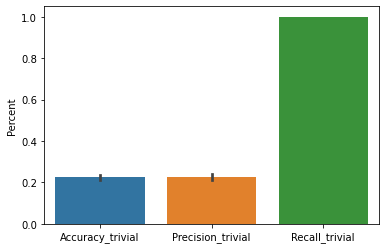

In [59]:
sns.barplot(data = pd.DataFrame({"Accuracy_trivial":accs_trivial, "Precision_trivial":precs_trivial, "Recall_trivial":recs_trivial}))
plt.ylabel("Percent")

#### Results on group prediction

In [60]:
start = time.time()
group_pred_measures = []
rng = np.random.default_rng(seed = 42)
for i in range(10):
    measures = []
    for file in os.listdir(GROUP_FOLDER):
        group = pd.read_csv(f'{GROUP_FOLDER}{file}').drop(columns = ['Unnamed: 0'])
        measures.append(measure_group_recommendation(trivial, group, None, rng))
    group_pred_measures.append(np.hstack(np.array(measures)).mean())
    print(f"Finished round {i}")
groups_trivial = group_pred_measures
end = time.time()
print(f"Time required to do the predictions on 10 rounds {end - start}")

Finished round 0
Finished round 1
Finished round 2
Finished round 3
Finished round 4
Finished round 5
Finished round 6
Finished round 7
Finished round 8
Finished round 9
Time required to do the predictions on 10 rounds 98.36086010932922


Text(0, 0.5, 'Score')

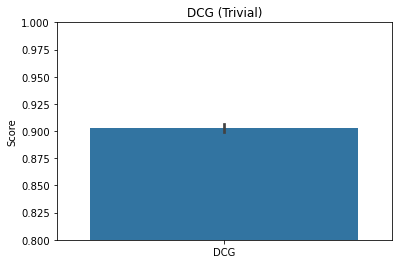

In [61]:
sns.barplot(data = pd.DataFrame(groups_trivial, columns = ["DCG"]))
plt.title("DCG (Trivial)")
plt.ylim(0.8, 1.0)
plt.ylabel("Score")

### Predicting only based on the user average listens

Trivially predict the mean of the user: $\large pred(u,i) = \mu_{u} = \sum_{k \in I(u)} \frac{Plays(u, k)}{|I(u)|}$

where, $u$ is the usere we're making the prediction for, $i$ is the artist we want to predict the number of plays, $I(u)$ is the set of Artist the user has listened to.

Have still to measure the performance ? How?

In [62]:
def compute_pred_avg_user(user, artist_i, avg_listens):
    return int(avg_listens[avg_listens['ID'] == user]['Plays'])

#### Results on individual prediction

In [63]:
start = time.time()
maes_users, accs_users, precs_users, recs_users = compute_n_rounds(compute_pred_avg_user)
end = time.time()
print(f"Time required to do the prediction on 10 rounds {end - start}")

===== Epoch 0 =====
===== Epoch 1 =====
===== Epoch 2 =====
===== Epoch 3 =====
===== Epoch 4 =====
===== Epoch 5 =====
===== Epoch 6 =====
===== Epoch 7 =====
===== Epoch 8 =====
===== Epoch 9 =====
Time required to do the prediction on 10 rounds 69.42635893821716


Text(0.5, 1.0, 'Mean absolute error on 10 runs (User Avg)')

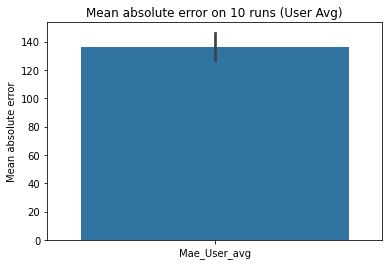

In [64]:
sns.barplot(data = pd.DataFrame(maes_users, columns = ["Mae_User_avg"]))
plt.ylabel("Mean absolute error")
plt.title("Mean absolute error on 10 runs (User Avg)")

Text(0, 0.5, 'Percent')

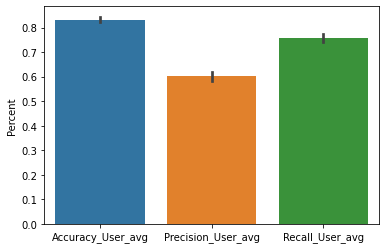

In [65]:
sns.barplot(data = pd.DataFrame({"Accuracy_User_avg":accs_users, "Precision_User_avg":precs_users, "Recall_User_avg":recs_users}))
plt.ylabel("Percent")

#### Results on group prediction

In [66]:
start = time.time()
group_pred_measures = []
rng = np.random.default_rng(seed = 42)
for i in range(10):
    measures = []
    for file in os.listdir(GROUP_FOLDER):
        group = pd.read_csv(f'{GROUP_FOLDER}{file}').drop(columns = ['Unnamed: 0'])
        measures.append(measure_group_recommendation(compute_pred_avg_user, group, group.groupby('ID').mean('Plays').reset_index(), rng))
    group_pred_measures.append(np.hstack(np.array(measures)).mean())
    print(f"Finished round {i}")
groups_user_avg = group_pred_measures
end = time.time()
print(f"Time required to do the predictions on 10 rounds {end - start}")

Finished round 0
Finished round 1
Finished round 2
Finished round 3
Finished round 4
Finished round 5
Finished round 6
Finished round 7
Finished round 8
Finished round 9
Time required to do the predictions on 10 rounds 161.81667518615723


Text(0, 0.5, 'Score')

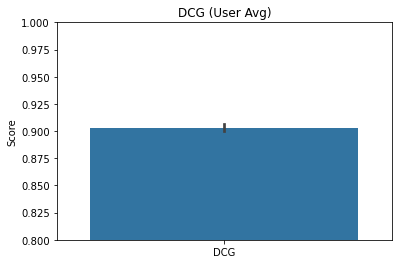

In [67]:
sns.barplot(data = pd.DataFrame(groups_user_avg, columns = ["DCG"]))
plt.title("DCG (User Avg)")
plt.ylim(0.8, 1.0)
plt.ylabel("Score")

### Predicting only based on the artist average listens


Trivially predict the mean of the artist for each user: $\large pred(u,i) = \mu_{i} =\sum_{v \in U(i)} \frac{Plays(v,i)}{|U(i)|}$

where $U(i)$ is the set of users that has listened artist i



In [68]:
def compute_pred_avg_artist(user, artist_i, avg_listens):
    prediction = avg_listens[avg_listens['Artist'] == artist_i]
    if len(prediction) == 0: 
        return int(avg_listens['Plays'].mean()) # What to return when we haven't seen the artist?
    else:
        return int(prediction['Plays'])

#### Results on individual prediction

In [69]:
start_artist = time.time()
maes_artists, accs_artists, precs_artists, recs_artists = compute_n_rounds(compute_pred_avg_artist)
end_artist = time.time()
print(f"Time required to do the prediction on 10 rounds {end_artist - start_artist}")

===== Epoch 0 =====
===== Epoch 1 =====
===== Epoch 2 =====
===== Epoch 3 =====
===== Epoch 4 =====
===== Epoch 5 =====
===== Epoch 6 =====
===== Epoch 7 =====
===== Epoch 8 =====
===== Epoch 9 =====
Time required to do the prediction on 10 rounds 76.42036008834839


Text(0.5, 1.0, 'Mean absolute error on 10 runs (Artist avg)')

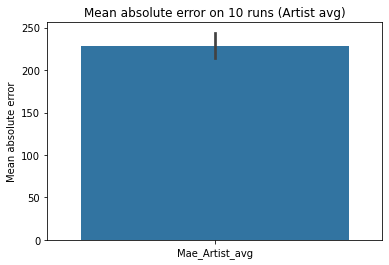

In [70]:
sns.barplot(data = pd.DataFrame(maes_artists, columns = ["Mae_Artist_avg"]))
plt.ylabel("Mean absolute error")
plt.title("Mean absolute error on 10 runs (Artist avg)")

Text(0, 0.5, 'Percent')

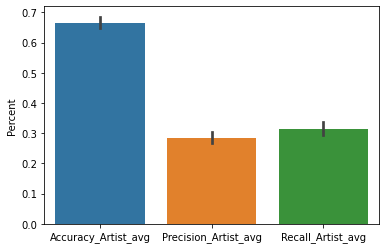

In [71]:
sns.barplot(data = pd.DataFrame({"Accuracy_Artist_avg":accs_artists, "Precision_Artist_avg":precs_artists, "Recall_Artist_avg":recs_artists}))
plt.ylabel("Percent")

#### Results on Group prediction

In [72]:
start = time.time()
group_pred_measures = []
rng = np.random.default_rng(seed = 42)
avg_artist_plays = top_merged.groupby('Artist').mean('Plays').reset_index()
for i in range(10):
    measures = []
    for file in os.listdir(GROUP_FOLDER):
        group = pd.read_csv(f'{GROUP_FOLDER}{file}').drop(columns = ['Unnamed: 0'])
        measures.append(measure_group_recommendation(compute_pred_avg_artist, group,
                                                     avg_artist_plays[avg_artist_plays['Artist'].isin(group['Artist'])] , rng))
    group_pred_measures.append(np.hstack(np.array(measures)).mean())
    print(f"Finished round {i}")
groups_artist_avg = group_pred_measures
end = time.time()
print(f"Time required to do the predictions on 10 rounds {end - start}")

Finished round 0
Finished round 1
Finished round 2
Finished round 3
Finished round 4
Finished round 5
Finished round 6
Finished round 7
Finished round 8
Finished round 9
Time required to do the predictions on 10 rounds 177.41017603874207


(0.8, 1.0)

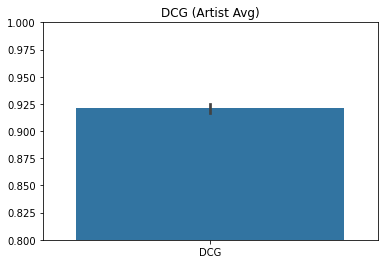

In [73]:
sns.barplot(data = pd.DataFrame(groups_artist_avg, columns = ["DCG"]))
plt.title("DCG (Artist Avg)")
plt.ylim(0.8, 1.0)

###  Using User similarity

**User specific prediction**: Compute similarity based on Jaccard distance: Each user has a set of artist he has listened to.

$\large sim(u,v)$ = Jacc$(I(u), I(v))$ = $\Large \frac{|I(u) \cap I(v)|}{|I(u) \cup I(v)|}$

Once we have this similarity, check if a new artist will be listened a lot by the user by comparing it to all the other users that have listened to him, this is the user-specific sum : 

$\large \tilde{u} =  \frac{\sum_{v \in U(i)} sim(u,v) \cdot (Plays(v,i) - \mu_{v})}{ \sum_{v \in U(i)} sim(u,v)} $

where $U(i)$ is the set of users that have listened to the group $i$

and add the mean of the user to it so we have:

$\large pred(u, i) = \mu_{u} + \tilde{u} $

In [74]:
def compute_pred_user_item(user, artist, df):
    user_artists = set(df[df['ID'] == user]['Artist']) #Get the set of the current user we want to get the prediction from
    artist_has_user = set(df[(df['Artist'] == artist) & (df['ID'] != user)]['ID']) #Set of artist that have rated the user
    
    num = 0
    denom = 0
    
    for i, x in enumerate(artist_has_user):
        user_i_artists = set(df[df['ID'] == x]['Artist'])
        sim_with_i = len(user_artists.intersection(user_i_artists))/len(user_artists.union(user_i_artists))
        
        num += sim_with_i * (int(df[(df['ID'] == x) & (df['Artist'] == artist)]['Plays']) - int(df[df['ID'] == x]['Plays'].mean()))
        denom += sim_with_i
    
    if denom == 0:
        return df[df['ID'] == user]['Plays'].mean()
    else:
        return df[df['ID'] == user]['Plays'].mean() + num/denom
    
    
    

#### Results on individual prediction

In [75]:
start_artist = time.time()
maes_sim, accs_sim, precs_sim, recs_sim = compute_n_rounds(compute_pred_user_item)
end_artist = time.time()
print(f"Time required to do the prediction on 10 rounds {end_artist - start_artist}")

===== Epoch 0 =====
===== Epoch 1 =====
===== Epoch 2 =====
===== Epoch 3 =====
===== Epoch 4 =====
===== Epoch 5 =====
===== Epoch 6 =====
===== Epoch 7 =====
===== Epoch 8 =====
===== Epoch 9 =====
Time required to do the prediction on 10 rounds 1240.679077386856


Text(0.5, 1.0, 'Mean absolute error on 10 runs (User sim)')

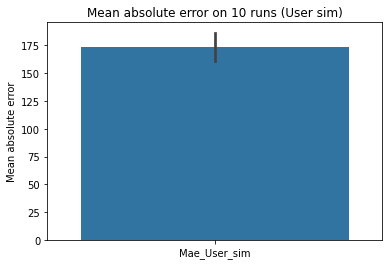

In [76]:
sns.barplot(data = pd.DataFrame(maes_sim, columns = ["Mae_User_sim"]))
plt.ylabel("Mean absolute error")
plt.title("Mean absolute error on 10 runs (User sim)")

Text(0, 0.5, 'Percent')

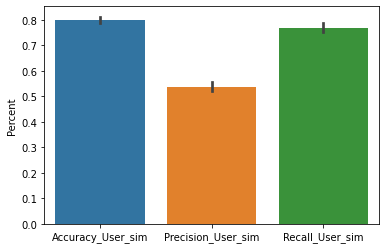

In [77]:
sns.barplot(data = pd.DataFrame({"Accuracy_User_sim":accs_sim, "Precision_User_sim":precs_sim, "Recall_User_sim":recs_sim}))
plt.ylabel("Percent")

#### Results on group prediction

**These were not done as the performance is less good than just doing the user average**

Furthermore it takes too much time as we always have to compute the prediction for all the users in the group and compute all the similarities again and again

In [78]:
"""
start = time.time()
group_pred_measures = []
df = top_merged.groupby('ID').size()
nb_users = len(df)
rng = np.random.default_rng(seed = 42)
for i in range(10):
    measures = []
    
    selected_users = rng.choice(nb_users, 500, replace = False) #Generate a random list of nb_users_select users
    subset_500_users = df[selected_users]
    subset = top_merged[top_merged.ID.isin(subset_500_users.index)] #Subset to compare our group members too
    
    for file in os.listdir(GROUP_FOLDER):
        group = pd.read_csv(f'{GROUP_FOLDER}{file}').drop(columns = ['Unnamed: 0'])
        measures.append(measure_group_recommendation(compute_pred_user_item, group,
                                                      subset, rng))
    group_pred_measures.append(np.array(measures).flatten().mean())
    print(f"Finished round {i}")
group_user_avg = group_pred_measures
end = time.time()
print(f"Time required to do the predictions on 10 rounds {end - start}")
"""

'\nstart = time.time()\ngroup_pred_measures = []\ndf = top_merged.groupby(\'ID\').size()\nnb_users = len(df)\nrng = np.random.default_rng(seed = 42)\nfor i in range(10):\n    measures = []\n    \n    selected_users = rng.choice(nb_users, 500, replace = False) #Generate a random list of nb_users_select users\n    subset_500_users = df[selected_users]\n    subset = top_merged[top_merged.ID.isin(subset_500_users.index)] #Subset to compare our group members too\n    \n    for file in os.listdir(GROUP_FOLDER):\n        group = pd.read_csv(f\'{GROUP_FOLDER}{file}\').drop(columns = [\'Unnamed: 0\'])\n        measures.append(measure_group_recommendation(compute_pred_user_item, group,\n                                                      subset, rng))\n    group_pred_measures.append(np.array(measures).flatten().mean())\n    print(f"Finished round {i}")\ngroup_user_avg = group_pred_measures\nend = time.time()\nprint(f"Time required to do the predictions on 10 rounds {end - start}")\n'

###  Using KNN

**User specific prediction**: Still computes similarity between the users but uses the only the k neirest neighbors to make the predictions.

$\large \tilde{u} =  \frac{\sum_{v \in KNN(i)} sim(u,v) \cdot (Plays(v,i) - \mu_{v})}{ \sum_{v \in KNN(i)} sim(u,v)} $

where $KNN(i)$ is the set of neighbors of $u$ that have listened to the group $i$.

and then do as before:

$\large p(u, i) = \mu_{u} + \tilde{u} $

In [79]:
def compute_pred_knn(user, artist, df, knn_df, model_knn):
    dists, indices = model_knn.kneighbors([knn_df.loc[user]])
    dists = dists[:,1:] #eliminate comparing user_i with himself
    indices = indices[:,1:] #eliminate comparing user_i with himself
    
    sims = 1-dists
    
    num = 0
    denom = 0
    
    for i in range(len(indices)):
        neighbor_i = knn_df.iloc[indices[0][i]].name
        nb_plays = get_nb_plays(neighbor_i, artist, df)
        
        if nb_plays != -1:
            num += sims[0][i] * (nb_plays - df[df['ID'] == neighbor_i]['Plays'].mean())
            denom += sims[0][i]
    
    if denom == 0 or num == 0:
        return df[df['ID'] == user]['Plays'].mean()
    else:
        return df[df['ID'] == user]['Plays'].mean() + num/denom
    

**HyperParameter Search**

In [80]:
start = time.time()
performances_df = pd.DataFrame()
for neighbors in [6,11,21,31, 51, 101]: #Corresponds to 5, 10, 20 
    maes_knn_i, accs_knn_i, precs_knn_i, recs_knn_i = compute_n_rounds(compute_pred_knn, n = 3, nb_users_selected = 500, n_neighbors = neighbors)
    #Only compute on 3 epochs as it takes a lot of time
    for i in range(len(maes_knn_i)):
        performances_df = performances_df.append({'neighbors':neighbors, 'mae_acc_prec_rec':maes_knn_i[i], 'measurement_method':'MAE'}, ignore_index = True)
        performances_df = performances_df.append({'neighbors':neighbors, 'mae_acc_prec_rec':accs_knn_i[i], 'measurement_method':'Accuracy'}, ignore_index = True)
        performances_df = performances_df.append({'neighbors':neighbors, 'mae_acc_prec_rec':precs_knn_i[i], 'measurement_method':'Precision'}, ignore_index = True)
        performances_df = performances_df.append({'neighbors':neighbors, 'mae_acc_prec_rec':recs_knn_i[i], 'measurement_method':'Recall'}, ignore_index = True)

end = time.time()
print(f"Time required to conduct hyperparameter search on 3 epochs for each K: {end - start}")

===== Epoch 0 =====
===== Epoch 1 =====
===== Epoch 2 =====
===== Epoch 0 =====
===== Epoch 1 =====
===== Epoch 2 =====
===== Epoch 0 =====
===== Epoch 1 =====
===== Epoch 2 =====
===== Epoch 0 =====
===== Epoch 1 =====
===== Epoch 2 =====
===== Epoch 0 =====
===== Epoch 1 =====
===== Epoch 2 =====
===== Epoch 0 =====
===== Epoch 1 =====
===== Epoch 2 =====
Time required to conduct hyperparameter search on 3 epochs for each K: 719.606734752655


Text(0, 0.5, 'Percent')

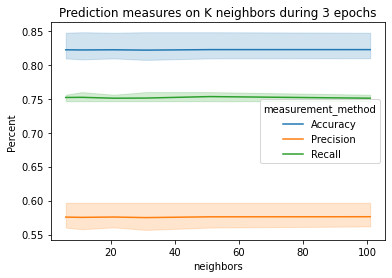

In [81]:
plt.title("Prediction measures on K neighbors during 3 epochs")
sns.lineplot(data = performances_df[performances_df['measurement_method'] != 'MAE'], x='neighbors', y='mae_acc_prec_rec', hue='measurement_method')
plt.ylabel("Percent")
#plt.savefig('K_Nearest_neighbour_measures.png')

The number of neighbors has almost no impact on the prediction result.

Text(0, 0.5, 'MAE')

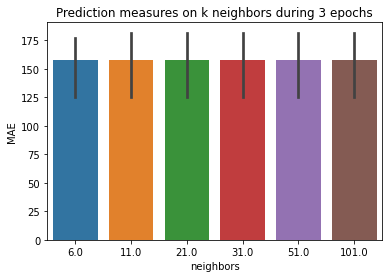

In [82]:
plt.title("Prediction measures on k neighbors during 3 epochs")
sns.barplot(data = performances_df[performances_df['measurement_method'] == 'MAE'], x='neighbors', y='mae_acc_prec_rec')
plt.ylabel("MAE")

In [83]:
performances_df[performances_df['measurement_method'] == 'MAE'].groupby('neighbors').mean()

,mae_acc_prec_rec
neighbors,
6.0,157.897677
11.0,157.934971
21.0,157.425338
31.0,157.819569
51.0,157.481561
101.0,157.775165


In [84]:
performances_df[performances_df['measurement_method'] == 'Accuracy'].groupby('neighbors').mean()

,mae_acc_prec_rec
neighbors,
6.0,0.821962
11.0,0.821712
21.0,0.821962
31.0,0.821466
51.0,0.822205
101.0,0.822209


In [85]:
performances_df[performances_df['measurement_method'] == 'Precision'].groupby('neighbors').mean()

,mae_acc_prec_rec
neighbors,
6.0,0.575766
11.0,0.575379
21.0,0.575864
31.0,0.575022
51.0,0.576184
101.0,0.576319


As the impact of the number of neighbours is really low, we therefore decide to not spend time trying to improve further by searching the best value of K and go with the number of neighbours that has the least mean-absolute-error which is 20.

In [86]:
start = time.time()
maes_knn, accs_knn, precs_knn, recs_knn = compute_n_rounds(compute_pred_knn, n_neighbors = 21)
end = time.time()
print(f"Time required to do the prediction on 10 rounds {end - start}")

===== Epoch 0 =====
===== Epoch 1 =====
===== Epoch 2 =====
===== Epoch 3 =====
===== Epoch 4 =====
===== Epoch 5 =====
===== Epoch 6 =====
===== Epoch 7 =====
===== Epoch 8 =====
===== Epoch 9 =====
Time required to do the prediction on 10 rounds 385.7896444797516


Text(0.5, 1.0, 'Mean absolute error on 10 runs (KNN)')

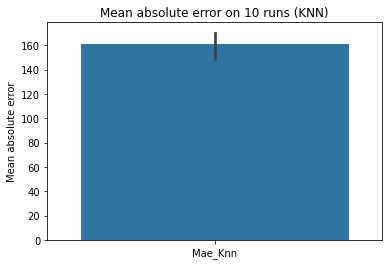

In [87]:
sns.barplot(data = pd.DataFrame(maes_knn, columns = ["Mae_Knn"]))
plt.ylabel("Mean absolute error")
plt.title("Mean absolute error on 10 runs (KNN)")

Text(0, 0.5, 'Percent')

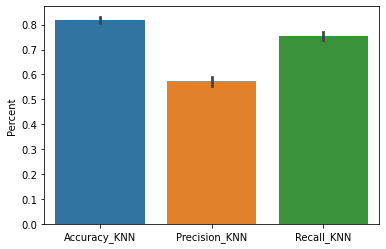

In [88]:
sns.barplot(data = pd.DataFrame({"Accuracy_KNN":accs_knn, "Precision_KNN":precs_knn, "Recall_KNN":recs_knn}))
plt.ylabel("Percent")

### Predicting based on the average number of plays per genre and user

The mean number of plays per genre and user is computed as : $\large pred(u,i) = \mu_{u,g} = \sum_{k \in I(u, g)} \frac{Plays(u, k)}{|I(u, g)|}$

where $u$ the user, $i$ the artist, $g$ the most common genre associated with the artist, and $I(u, g)$ the set of artists listened to by the user which have the same most common genre as the artist for which we are computing the prediction.


In [89]:
mean_genres_users = top_merged.groupby(['ID', 'Most_common_genre'])['Plays'].mean()
mean_genres_users = mean_genres_users.reset_index()
mean_genres_users

,ID,Most_common_genre,Plays
0,00000c289a1829a808ac09c00daf10bc3c4e223b,alternative metal,174.500000
1,00000c289a1829a808ac09c00daf10bc3c4e223b,alternative rock,242.500000
2,00000c289a1829a808ac09c00daf10bc3c4e223b,country,145.000000
3,00000c289a1829a808ac09c00daf10bc3c4e223b,dance pop,248.000000
4,00000c289a1829a808ac09c00daf10bc3c4e223b,dance-punk,281.000000
...,...,...,...
6779827,ffff9ef87a7d9494ada2f9ade4b9ff637c0759ac,new age,80.000000
6779828,ffff9ef87a7d9494ada2f9ade4b9ff637c0759ac,norwegian metal,166.000000
6779829,ffff9ef87a7d9494ada2f9ade4b9ff637c0759ac,power metal,92.750000
6779830,ffff9ef87a7d9494ada2f9ade4b9ff637c0759ac,progressive power metal,128.000000


In [90]:
def compute_pred_genre_avg_user(user, artist, mean_genres_users, artist_most_common) :
    most_common = artist_most_common[artist_most_common['Artist'] == artist].Most_common_genre.iloc[0]
    return mean_genres_users[(mean_genres_users['ID'] == user) & (mean_genres_users['Most_common_genre'] == most_common)].Plays.iloc[0]

**Testing individual predictions**

**Previous function doesn't match the need of this method**

In [91]:
def compute_mae_and_app_genre(test_df, mean_genres_users, artist_most_common, threshold = 100):
    predictions = np.zeros(len(test_df))
    reals = np.zeros(len(test_df))
    indice = 0
    mae = 0
    for i, row in test_df.iterrows():
        user = row.ID
        artist = row.Artist
        prediction = compute_pred_genre_avg_user(user, artist, mean_genres_users, artist_most_common)
        mae += abs(row.Plays - prediction)
        predictions[indice] = prediction > threshold
        reals[indice] = row.Plays > threshold
        indice += 1
    
    tp = np.sum(np.bitwise_and(predictions==1, reals == 1))
    fp = np.sum(np.bitwise_and(predictions==1, reals == 0))
    
    fn = np.sum(np.bitwise_and(predictions== 0, reals == 1))
    
    acc = np.sum(predictions == reals)
    
    return mae/len(test_df), acc/len(test_df), tp/(tp+fp), tp/(tp + fn)

In [92]:
def compute_n_rounds_genre(nb_users_selected = 500, n = 10, seed = 42):
    """
    Computes the mae, accuracy, precision and recall on n round of the pred_method
    
    pred_method = method that allows to compute the prediction
    nb_users_selected = number of users in the sub-sample
    n = number of rounds
    seed = seed for random generation of sub-samples
    """
    np.random.seed(seed)
    maes, accs, precs, recs = [],[],[],[]
    df = top_merged[['ID', 'Artist', 'Plays']]
    df2 = df.groupby('ID').size()
    nb_users = len(top_merged.ID.unique())
    
    for i in range(n):
        print(f"===== Epoch {i} =====")
        selected_users = np.random.randint(0, nb_users, nb_users_selected) #Generate a random list of nb_users_select users
        subset_500_users = df2[selected_users]
        subset = df[df.ID.isin(subset_500_users.index)]
        train, test = split_train_test(subset, train_size=0.95)
        test_genre_users = mean_genres_users[mean_genres_users.ID.isin(test.ID)]
        
        mae, acc, prec, rec = compute_mae_and_app_genre(test, test_genre_users, add_data[['Artist', 'Most_common_genre']])
        
        maes.append(mae)
        accs.append(acc)
        precs.append(prec)
        recs.append(rec)
        
    return maes, accs, precs, recs

In [93]:
def test_recommender_genre(df, mean_genres_users, artist_most_common, group_of_users, same_artists, threshold = 250):
    list_of_artists = dict()
    
    for user in group_of_users:
        nb_likes = 0
        for artist in same_artists:
            list_of_artists[artist] = 0
    
    for artist in list_of_artists.keys():
        for user in group_of_users:
            if(user == group_of_users[0]): #Always takes first user because selection is randomized
                nb_plays = get_nb_plays(user, artist, df)
            
            else: nb_plays = -1
                
            if nb_plays != -1:
                if nb_plays > threshold:
                    list_of_artists[artist] += 1
            
            else:
                prediction = compute_pred_genre_avg_user(user, artist, mean_genres_users, artist_most_common)
                if prediction > threshold:
                    list_of_artists[artist] += 1
    
    recommendation = pd.DataFrame(columns = ["Artist", "nb_likes"])
    
    for entry in list_of_artists:
        recommendation = recommendation.append({"Artist":entry, "nb_likes":list_of_artists[entry]}, ignore_index = True)
    
    return recommendation.sort_values("nb_likes", ascending = False).reset_index().drop(columns = "index")

In [94]:
def measure_group_recommendation_genre(mean_genres_users, artist_most_common, group_df, rng):
    users = group_df['ID'].unique()
    mean_genres_users_group = mean_genres_users[mean_genres_users['ID'].isin(users)]
    measures = []
    rng = rng
    for nb_pred in range(10):
        random_6_users = rng.choice(len(users), 6, replace = False)
        my_6_users_group = users[random_6_users]

        aggregated_set = group[group['ID'].isin(users)][['ID','Artist']].groupby('ID').agg(set)
        same_artists = aggregated_set.iloc[0]['Artist']
        for i,row in aggregated_set.iterrows():
            same_artists = same_artists.intersection(row['Artist'])

        random_5_artists = np.array(list(same_artists))
        random_5_artists = random_5_artists[rng.choice(len(same_artists), 5, replace = False)]

        real = get_group_recommendation_according_to_our_algorithm(my_6_users_group, random_5_artists, group)
        pred = test_recommender_genre(group, mean_genres_users_group, add_data[['Artist', 'Most_common_genre']], my_6_users_group, random_5_artists)
        measures.append(dcg_idcg(real, pred))
    return measures

#### Individual prediction

In [95]:
import time
start = time.time()
maes_genres, accs_genres, precs_genres, recs_genres = compute_n_rounds_genre()
end = time.time()
print(f"Time required to do the prediction on 10 rounds {end - start}")

===== Epoch 0 =====
===== Epoch 1 =====
===== Epoch 2 =====
===== Epoch 3 =====
===== Epoch 4 =====
===== Epoch 5 =====
===== Epoch 6 =====
===== Epoch 7 =====
===== Epoch 8 =====
===== Epoch 9 =====
Time required to do the prediction on 10 rounds 81.75360798835754


Text(0.5, 1.0, 'Mean absolute error on 10 runs (Genre avg)')

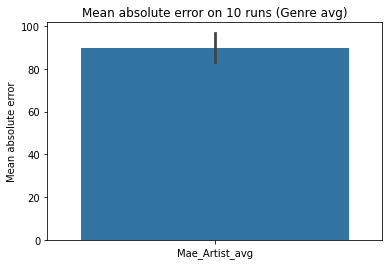

In [96]:
sns.barplot(data = pd.DataFrame(maes_genres, columns = ["Mae_Artist_avg"]))
plt.ylabel("Mean absolute error")
plt.title("Mean absolute error on 10 runs (Genre avg)")

Text(0, 0.5, 'Percent')

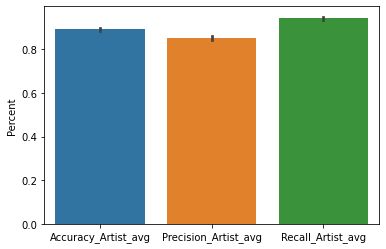

In [97]:
sns.barplot(data = pd.DataFrame({"Accuracy_Artist_avg":accs_genres, "Precision_Artist_avg":precs_genres, "Recall_Artist_avg":recs_genres}))
plt.ylabel("Percent")

In [98]:
start = time.time()
group_pred_measures = []
rng = np.random.default_rng(seed = 42)

for i in range(10):
    measures = []
    for file in os.listdir(GROUP_FOLDER):
        group = pd.read_csv(f'{GROUP_FOLDER}{file}').drop(columns = ['Unnamed: 0'])
        measures.append(measure_group_recommendation_genre(mean_genres_users, add_data[['Artist', 'Most_common_genre']], group, rng))
    group_pred_measures.append(np.hstack(np.array(measures)).mean())
    print(f"Finished round {i}")
groups_genres = group_pred_measures
end = time.time()
print(f"Time required to do the predictions on 10 rounds {end - start}")

Finished round 0
Finished round 1
Finished round 2
Finished round 3
Finished round 4
Finished round 5
Finished round 6
Finished round 7
Finished round 8
Finished round 9
Time required to do the predictions on 10 rounds 188.0261881351471


Text(0, 0.5, 'Score')

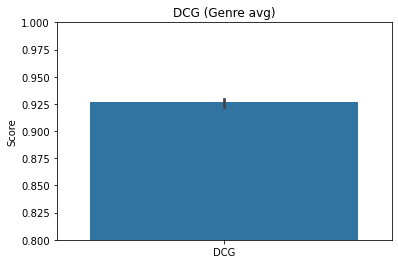

In [99]:
sns.barplot(data = pd.DataFrame(groups_genres, columns = ["DCG"]))
plt.title("DCG (Genre avg)")
plt.ylim(0.8, 1.0)
plt.ylabel("Score")

## 8. Comparison between techniques

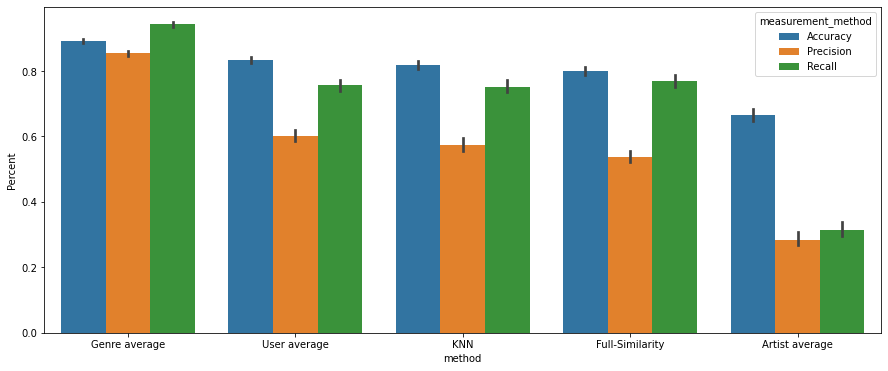

In [100]:
fig = plt.figure(figsize= (15,6))
measurments_df = pd.DataFrame(columns = ['method', 'mae_acc_prec_rec', 'measurement_method']) 


for i in range(len(maes_genres)):
    measurments_df= measurments_df.append({'method':'Genre average', 'mae_acc_prec_rec':maes_genres[i], 'measurement_method':'MAE'}, ignore_index = True)
    measurments_df= measurments_df.append({'method':'Genre average', 'mae_acc_prec_rec':accs_genres[i], 'measurement_method':'Accuracy'}, ignore_index = True)
    measurments_df= measurments_df.append({'method':'Genre average', 'mae_acc_prec_rec':precs_genres[i], 'measurement_method':'Precision'}, ignore_index = True)
    measurments_df= measurments_df.append({'method':'Genre average', 'mae_acc_prec_rec':recs_genres[i], 'measurement_method':'Recall'}, ignore_index = True)

for i in range(len(maes_users)):
    measurments_df= measurments_df.append({'method':'User average', 'mae_acc_prec_rec':maes_users[i], 'measurement_method':'MAE'}, ignore_index = True)
    measurments_df= measurments_df.append({'method':'User average', 'mae_acc_prec_rec':accs_users[i], 'measurement_method':'Accuracy'}, ignore_index = True)
    measurments_df= measurments_df.append({'method':'User average', 'mae_acc_prec_rec':precs_users[i], 'measurement_method':'Precision'}, ignore_index = True)
    measurments_df= measurments_df.append({'method':'User average', 'mae_acc_prec_rec':recs_users[i], 'measurement_method':'Recall'}, ignore_index = True)

for i in range(len(maes_knn)):
    measurments_df= measurments_df.append({'method':'KNN', 'mae_acc_prec_rec':maes_knn[i], 'measurement_method':'MAE'}, ignore_index = True)
    measurments_df= measurments_df.append({'method':'KNN', 'mae_acc_prec_rec':accs_knn[i], 'measurement_method':'Accuracy'}, ignore_index = True)
    measurments_df= measurments_df.append({'method':'KNN', 'mae_acc_prec_rec':precs_knn[i], 'measurement_method':'Precision'}, ignore_index = True)
    measurments_df= measurments_df.append({'method':'KNN', 'mae_acc_prec_rec':recs_knn[i], 'measurement_method':'Recall'}, ignore_index = True)

for i in range(len(maes_sim)):
    measurments_df= measurments_df.append({'method':'Full-Similarity', 'mae_acc_prec_rec':maes_sim[i], 'measurement_method':'MAE'}, ignore_index = True)
    measurments_df= measurments_df.append({'method':'Full-Similarity', 'mae_acc_prec_rec':accs_sim[i], 'measurement_method':'Accuracy'}, ignore_index = True)
    measurments_df= measurments_df.append({'method':'Full-Similarity', 'mae_acc_prec_rec':precs_sim[i], 'measurement_method':'Precision'}, ignore_index = True)
    measurments_df= measurments_df.append({'method':'Full-Similarity', 'mae_acc_prec_rec':recs_sim[i], 'measurement_method':'Recall'}, ignore_index = True)

for i in range(len(maes_artists)):
    measurments_df= measurments_df.append({'method':'Artist average', 'mae_acc_prec_rec':maes_artists[i], 'measurement_method':'MAE'}, ignore_index = True)
    measurments_df= measurments_df.append({'method':'Artist average', 'mae_acc_prec_rec':accs_artists[i], 'measurement_method':'Accuracy'}, ignore_index = True)
    measurments_df= measurments_df.append({'method':'Artist average', 'mae_acc_prec_rec':precs_artists[i], 'measurement_method':'Precision'}, ignore_index = True)
    measurments_df= measurments_df.append({'method':'Artist average', 'mae_acc_prec_rec':recs_artists[i], 'measurement_method':'Recall'}, ignore_index = True)


sns.barplot(data =  measurments_df[measurments_df['measurement_method']!= 'MAE'] , x= 'method', y='mae_acc_prec_rec', hue='measurement_method')
plt.ylabel('Percent')

plt.savefig('data/all_measurements.png')

### MAE comparison

Text(0, 0.5, 'MAE')

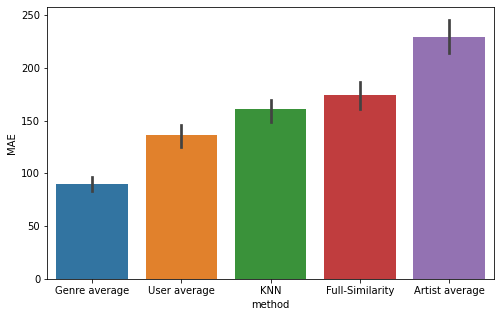

In [101]:
fig = plt.figure(figsize = (8,5))
sns.barplot(data =  measurments_df[measurments_df['measurement_method']== 'MAE'] , x= 'method', y='mae_acc_prec_rec')
plt.ylabel('MAE')
#plt.savefig('data/mae.png')

### Group measurements (Only on bests method)

In [102]:
NDCG_measures_df =  pd.DataFrame()

for i in range(len(groups_genres)):
    NDCG_measures_df = NDCG_measures_df.append({'method':'Genre average', 'ndcg':groups_genres[i], 'measurement_method':'NDCG'}, ignore_index = True)
    NDCG_measures_df = NDCG_measures_df.append({'method':'User average', 'ndcg':groups_user_avg[i], 'measurement_method':'NDCG'}, ignore_index = True)

(0.8, 1.0)

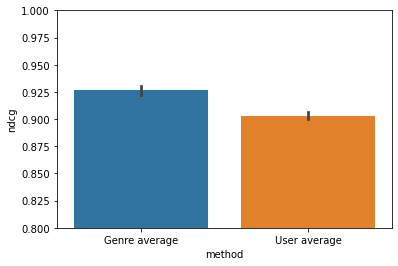

In [103]:
sns.barplot(data = NDCG_measures_df, x="method", y="ndcg")
plt.ylim(0.8, 1)
#plt.savefig('data/ndcg_idcg.png')

Example of a prediction with the reality and the final group prediction score:

In [104]:
for file in os.listdir(GROUP_FOLDER):
    group = pd.read_csv(f'{GROUP_FOLDER}{file}').drop(columns = ['Unnamed: 0'])
    users = group['ID'].unique()
    random_6_users = rng.choice(len(users), 6, replace = False)
    my_6_users_group = users[random_6_users]
        
    aggregated_set = group[group['ID'].isin(users)][['ID','Artist']].groupby('ID').agg(set)
    same_artists = aggregated_set.iloc[0]['Artist']
    for i,row in aggregated_set.iterrows():
        same_artists = same_artists.intersection(row['Artist'])
        
    random_5_artists = np.array(list(same_artists))
    random_5_artists = random_5_artists[rng.choice(len(same_artists), 5, replace = False)]
    
    real = get_group_recommendation_according_to_our_algorithm(my_6_users_group, random_5_artists, group)
    mean_genres_group = mean_genres_users[mean_genres_users['ID'].isin(my_6_users_group)]
    pred = test_recommender_genre(group, mean_genres_group, add_data[['Artist', 'Most_common_genre']], my_6_users_group, random_5_artists)
    break

In [105]:
real

,Artist,nb_likes
0,radiohead,4
1,air,3
2,muse,2
3,the beatles,1
4,sigur rós,1


In [106]:
pred

,Artist,nb_likes
0,air,3
1,radiohead,2
2,muse,1
3,the beatles,1
4,sigur rós,1


In [107]:
dcg_idcg(real, pred)

1.0